# Predict Kinase Activities

Once your dataset has been mapped, you are ready to generate kinase activity predictions. Kinase activity calculation requires selection of the following choices

1. Type of kinases to predict activity for (tyrosine (Y) or serine/threonine (ST)) 
2. How to handle duplicate sites with multiple quantification values (default is to take the mean)
3. Which sites to use as evidence of kinase activity for each data column. This can be defined in two ways:
    - By threshold: use sites with quantification greater than or less than some threshold value (recommended for comparison data like fold changes)
    - By evidence size: use the top (or bottom) N sites for each dataset so that each dataset uses the same number of sites (recommended for single sample data)

In this tutorial, we are using phosphotyrosine-enriched experimental data comparing an untreated condition to TCR activation, so we will predict tyrosine kinase activity using a determined threshold. First, we need to decide what threshold to use.

## Determine Thresholds
It is useful to determine the best threshold to use (which sites to use as evidence for each sample). The goal with determining a threshold is to pick a value that results in enough evidence for prediction (around 150-200 for Y and 1500-2000 for ST) and similarity between samples is low. For this purpose, we have provided several functions for assessing different possible thresholds using the KinaseActivity class.

First, we'll need to define our output directory and run name as we did for mapping:

In [14]:
import pandas as pd

#define the directory where mapped dataset and run information will be saved. 
odir = './example'
name = 'example_run'

#load mapped data, if necessary
experiment = pd.read_csv(f'{odir}/MAPPED_DATA/{name}_mapped.csv', index_col = 0)

Next, we need to define the parameters to use for the generation of evidence in this experiment. These parameters include:

1. __data_columns__: the location of abundance values from phosphoproteomic experiment. Either can provide a list of column names, or if is None, KSTAR will look for any column that contains 'data:' at the beginning of the name. Since the example dataset includes this 'data:' format, we will set this parameter to None.

2. __phospho_type__: type of kinase to generate predictions for

2. __agg__: We would like phosphorylation sites select sites based on the their abundance relative to the pre-stimulation condition, with sites appearing multiple times aggregated using a mean. As such, we will set this to be 'mean'. Other options include 'max' or 'min', which will take the maximum or minimum value seen across multiple sites. Last option is 'count', which will count the number of times a site appears across the dataset. This is good if you would like to use all sites observed in a sample (set threshold to 1).

3. __greater__: boolean that indicates whether sites greater than or less than the threshold should be kept. We are interested in knowing which kinases activate upon TCR stimulation, so we want to look at phosphorylation sites with phosphorylation. For this reason, we will set greater = True.

In [15]:
#Define parameters
data_columns = None
agg = 'mean' 
greater = True

For all activity prediction steps, the KinaseActivity class (found within the calculate module) is used. We can then test a range of thresholds from 0 to 2 and explore its impact on evidence size and similarity between datasets

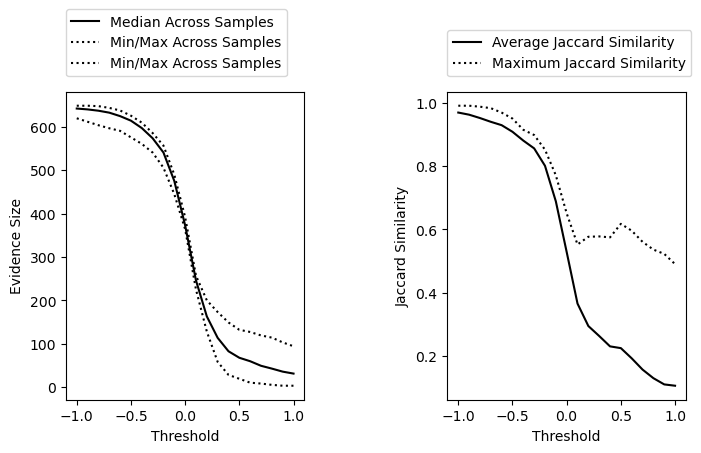

In [16]:
from kstar import calculate

#intialize KinaseActivity class object
kinact = calculate.KinaseActivity(experiment, odir = odir, name = name, data_columns = data_columns, phospho_type='Y')
#define the minimum and maximum threshold you would like to use for activity calculation
min_threshold = -1
max_threshold = 2
#test a range of thresholds to determine the best one for your dataset
kinact.test_threshold_range(min_threshold = min_threshold, max_threshold = max_threshold)

We can see that as we increase the threshold, we reduce the similarity between datasets but also the overall evidence size. Based on this, we might want to use a threshold around 0 depending on how stringent we want to be. We can also get specific recommendations for thresholds using the `recommend_threshold()` function.

In [18]:
threshold = kinact.recommend_threshold(desired_evidence_size = 200, agg = agg, greater = greater, min_threshold =0)

Recommended threshold based on median evidence_size: 0.2 (median sites = 163.0)
Recommended threshold based on max similarity: 0.0 (max Jaccard similarity = 0.65)
Final recommended threshold = 0.2)


We can see based on the recommendation something similarity to what we observed from the above plots. We reduce the similarity between samples with a threshold around 0, but to get to a desired_evidence_size of 200, we need a slightly more stringent threshold of 0.2. Let's move forward with a threshold of 0.2. 

Should you want more specific details about the data at this threshold, you can also use the `test_threshold()` function

Number of Sites That Will Be Used As Evidence For Each Sample:
Maximum = 200
Minimum = 128
Median = 163.0


Average Jaccard Similarity Between Samples: 0.294
Maximum Jaccard Similarity Between Samples: 0.577


Number of columns without enough evidence (min = 0): 0


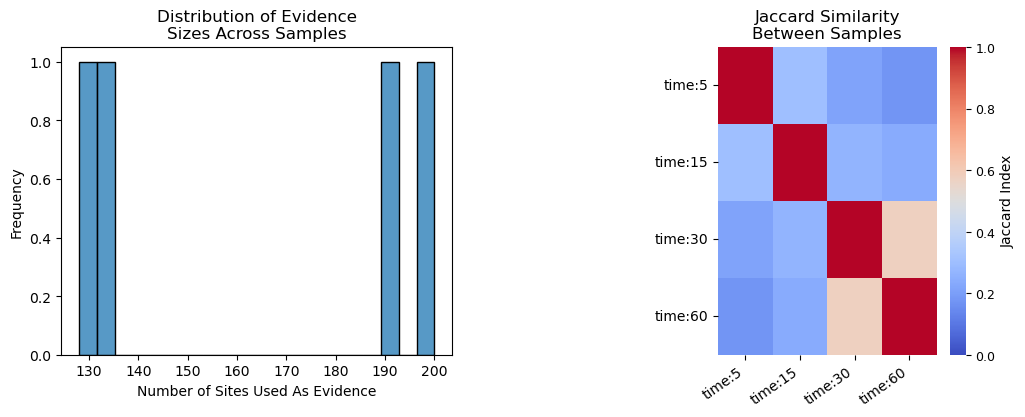

In [20]:
kinact.test_threshold(threshold = 0.2, plot = True)

## KSTAR Run with Default Parameters

Now that we have determined how evidence will be identified, we can proceed to generated kinase activity predictions. The easiest way to do this will be to run the `run_kstar_analysis()` function. This will perform the three major operations of KSTAR:
1. `enrichment_analysis()`: calculate statistical enrichment of a kinase's substrates within each sample using each of the 50 pruned networks
2. `randomized_analysis()`: generate random experiments with similar properities as the real experiment and repeat statistical enrichment
3. `Mann_Whitney_analysis()`: compare the enrichment observed from the real experiment to the random experiments to calculate final activity scores and false positive rates

To run, simply define the aforementioned parameters and go! This will output a dictionary of KinaseActivity objects, one for tyrosine kinases and one for serine/threonine kinases (if both predictions were desired)

*Note: if your machine is capable of multiprocessing, we strongly recommend setting PROCESSES > 1 to increase the speed of activity calculation*

In [8]:
from kstar import calculate
import pandas as pd

#define key parameters (for more options, see full function documentation)
odir = './example'
name = 'example_run'
data_columns = None
greater = True
threshold = 0.2
phospho_types = ['Y']  

#only need to define network information if not using default KSTAR networks
network_dir = None
network_name = None

#if you want to automatically save results
save_results = True

#load mapped data, if necessary
experiment = pd.read_csv(f'{odir}/MAPPED_DATA/{name}_mapped.csv', index_col = 0)

#run master activity calculation function
kinact_dict = calculate.run_kstar_analysis(experiment, 
                                           odir = odir, 
                                           name = name,
                                           data_columns = data_columns,
                                           phospho_types = phospho_types,
                                           threshold = threshold,
                                           greater = greater,
                                           save_results = save_results,
                                           PROCESSES = 6)

Starting kinase-substrate enrichment analysis...
Starting calculation of random activities...
Loading pre-generated random activities for datasets where applicable...
2 out of 4 columns did not have appropriate pregenerated random enrichment and will calculate from scratch: data:time:5, data:time:15


Calculating activities from random experiments for each column not using pregenerated random activities: 100%|██████████| 2/2 [02:28<00:00, 74.39s/it]


Comparing kinase-substrate enrichment from the real experiment to random experiments...


Calculating final activities with the mann whitney U test: 100%|██████████| 4/4 [00:20<00:00,  5.08s/it]

Saving KSTAR analysis results in ./example/RESULTS/
Done.


*Note, if you are using KSTAR networks other than the defaults, you will need to explicitly define where to find these networks using the `network_dir` and `network_name` parameters*

## Saving KSTAR Results

There are a couple of options to save the results of KSTAR analysis. To save information needed for most downstream analysis (binarized experiment, mann whitney activities), we have provided a function to save while not taking up too much memory. This will also save the parameters used for prediction as a .json file.

In [ ]:
calculate.save_kstar(kinact_dict, name, odir, minimal = True)

If you would like to save all KSTAR files, including random experiments and hypergeometric enrichment within each network, you can change `minimal = False`.

Lastly, it is possible to just save each KinaseActivity attribute individually using pandas:

In [ ]:
kinact_dict['Y'].activities_mann_whitney.to_csv(f'{name}_Y_mann_whitney_activities.tsv', sep = '\t')
kinact_dict['Y'].fpr_mann_whitney.to_csv(f'{name}_Y_mann_whitney_fpr.tsv', sep = '\t')

## Other Considerations

The above tutorial walks through all of the information needed to run KSTAR for the typical user. However, there are additional ways to adjust how KSTAR calculations take place, desscribed in this section

### Using Pregenerated Experiments (or Not)

In KSTARv1.0, we introduced the use of random experiments that were pre-generated and reused for future activity predictions, rather than generated at the time of activity prediction. This significantly reduced computational time, but does mean that the random experiments likely do not exactly match the true experiment as they did in the original implementation of KSTAR. 

By default, KSTAR will use pregenerated random experiments with a similar size and bias distribution as the real experiment (>150 sites, within 25% of the pregenerated number of sites). If there are no appropriate pregenerated experiments, the random experiments will be generated from scratch. While we did not find significant impact on results when using pregenerated experiments, users may wish to default to the original, published version of the algorithm. Should you wish to adjust the default behavior of KSTAR, you can tweak the below parameters that can be passed to `run_kstar_analysis()`:
- `use_pregen_data`: set to False to not use pregenerated random experiments (default = True)
- `max_diff_from_pregenerated`: maximum fractional difference between the number of sites in the real and pregenerated experiments (default = 0.25)
- `min_dataset_size_for_pregenerated`: minimum number of sites required to use pregenerated random experiments
-`require_pregenerated`: if True, will ignore data columns that do not have an appropriate pregenerated experiment. This will help improve speed, but may cause dataset loss

In addition, you may wish to generate additional pre-generated experiments that can be used in the future for cases where there is not an appropriate pre-generated experiment already existing. In this case, you should provide a specific directory where these experiments should be stored:
- `custom_pregenerated_path`: where additional pre-generated experiments are stored and will be saved to if `save_new_random_activities=True`
- `save_new_random_activities`: save newly generated random experiments in the `custom_pregenerated_path`
- `default_pregen_only`: if True, will ignore any experiments in the `custom_pregenerated_path`